<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
#!pip install skimage
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git


try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import save_img
mpl.rcParams['figure.figsize'] = (12, 5)

AUTOTUNE = tf.data.experimental.AUTOTUNE


import IPython.display as display
from PIL import Image
import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/Stage_cropped.zip


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  #print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #data = pd.read_csv('/content/training.csv')
  #names = data[:,0]
  #id = patterns[patterns == lab]
  #for part in parts:
   # print(part)
  lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  height = input_shape[0]
  width = input_shape[1]

  if (img.shape[0] < img.shape[1]):
    img = tf.image.resize(img, [width, height])
    #print("height < width")
    img = tf.image.transpose(img)
  else:
    img = tf.image.resize(img, [height, width])
    #print("height > width")

  return img


def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

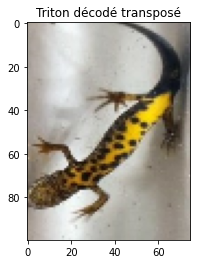

In [3]:
def prepare_img(input_shape,img_path):

  height = input_shape[0]
  width = input_shape[1]
  channel = input_shape[2]




  img = tf.io.read_file(img_path)

  try:
    img = decode_img(img)
  # print(img)
    #plt.title('Triton décodé')
  #plt.imshow(img)
  except:
    pass
  

  return img


input_shape = (100,75,3)
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img = prepare_img(input_shape,img_path)
plt.title('Triton décodé transposé')
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 75, 3)


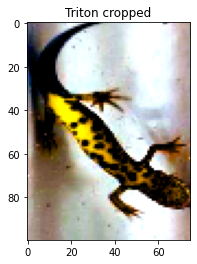

In [4]:
print(img.shape)
#image = tf.image.random_crop(img, size=[40, 40, 3])
image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
image = tf.image.random_flip_left_right(image)
image = tf.image.random_flip_up_down(image)
image = tf.image.random_contrast(image,0.5,3)
image = tf.image.random_saturation(image,0.5,3)
plt.title('Triton cropped')
plt.imshow(image)

In [14]:
#data = pd.read_csv('/content/training.csv',)
def augmentationImage(img_path,img_aug_path):

  input_shape = (100,75,3)
  
  !rm -rf /content/databaseAug
  data = pd.read_csv('/content/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = '/content/database'
  with os.scandir(img_path) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < int(500/count)):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
          image = tf.image.random_flip_left_right(image)
          image = tf.image.random_flip_up_down(image)
          image = tf.image.random_contrast(image,0.5,3)
          image = tf.image.random_saturation(image,0.5,3)
          
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          save_img(augPath, image)

          k += 1

img_path = '/content/database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path)

Création de la base de données augmentées en cours...


Séparation en train et test set

In [15]:

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..

import fnmatch



for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=10, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

Streaming output truncated to the last 5000 lines.
/content/databaseAug/train/KM00477/Bascha_P01_T03_K11_M_Adult_218_20190517030718482.jpg
500
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_2019043022463395.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633258.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_201904302246335.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633431.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633211.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633394.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633158.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633181.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633236.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adu

In [0]:


def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  #print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #for part in parts:
   # print(part)
  #lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  #lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES
  #assert not id.empty 
  #print(id.index)

 # id = ids.iloc[id.index]
  #print(id)
  # The second to last is the class-directory
  #print(type(tf.convert_to_tensor(id)))
  #return tf.convert_to_tensor(id)[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [width, height])

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

In [9]:
length = len(os.listdir('/content/databaseAug/train/KM00666'))
print(length)


179


500


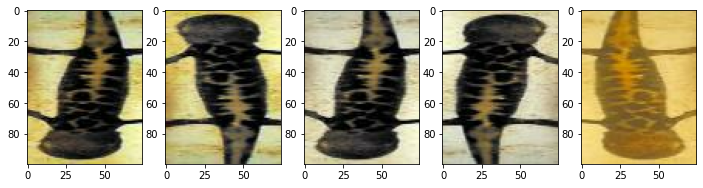

In [0]:
def visualize(label_path):
  fig = plt.figure()
  images = os.listdir(label_path)
  for i in range(1,6):
    plt.subplot(1,5,i)
    #plt.title('Original image')
    img_path = label_path + '/' + images[i-1]
    img = tf.io.read_file(img_path)
    img = decode_img(img)
    plt.imshow(img)

visualize('/content/databaseAug/train/KM00083')

In [0]:

!rm -rf /content/databaseAug
data = pd.read_csv('/content/training.csv')
labels = data.iloc[1:,4]
labels.head()
labels = np.unique(labels)
for label in labels:
  os.makedirs('databaseAug/train/'+label)
  os.makedirs('databaseAug/test/'+label)



In [0]:



ds_path = "/content/content/Stage/database/dataset_regroupe"
ds_path = pathlib.Path(ds_path)

ds_dir = os.listdir(ds_path)

CLASS_NAMES = []

for pattern in ds_dir:
  i = 0
  while (pattern[i] != "_"):
    i += 1
  CLASS_NAMES.append(pattern[:i])
  #print(pattern[:i])

CLASS_NAMES = np.array(CLASS_NAMES)
CLASS_NAMES = np.unique(CLASS_NAMES)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.flip_left_right(image)

  return image,label

FileNotFoundError: ignored